# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, batch_size=1):
    pred=model.predict(x.reshape(batch_size,n_timesteps_in,n_features), batch_size=batch_size)
    print('input', one_hot_decode(x[0]))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real[0]))

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def get_weights(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
    attention_plot = np.zeros((batch_size,n_timesteps_in, n_timesteps_in))
    encoder_inputs = seq_in.reshape(batch_size, n_timesteps_in, n_features)
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float64)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    states = [state_h, state_c]
    all_outputs = []
    decoder_input_data = np.zeros((batch_size, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 
    inputs = decoder_input_data
    #initial hiiden state
    decoder_outputs = state_h
    # decoder will only process one timestep at a time.
    for t in range(n_timesteps_in):
        # pay attention
        context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (batch_size, n_timesteps_in))
        attention_plot[:, t, :] = attention_weights.numpy()
        decoder_outputs=tf.expand_dims(decoder_outputs, 1)
        context_vector = tf.expand_dims(context_vector, 1)
        inputs = tf.concat([context_vector, inputs], axis=-1)
        decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)    
        outputs = decoder_dense(decoder_outputs)
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        inputs = outputs
        states = [state_h, state_c]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])

    return seq_in, seq_out, attention_plot

def plot_attention(attention_plot, sequence, predicted_sequence):
    print(attention_plot.shape)
    fig = plt.figure(figsize=(19,19))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_plot[0], cmap='viridis')
    fontdict = {'fontsize': 10}
    ax.set_xticklabels([''] + one_hot_decode(sequence[0]), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay =!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)
        
        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [4]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 10

# model parameters
rnn_units = 80

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

2022-01-03 17:05:28.429165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:05:28.526561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:05:28.527249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:05:28.528899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-01-03 17:05:52.287538: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-03 17:07:29.497801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 165s 339ms/step - loss: 2.9418 - accuracy: 0.0646 - val_loss: 2.9181 - val_accuracy: 0.0800
Epoch 2/50
180/180 [==============================] - 32s 179ms/step - loss: 2.9004 - accuracy: 0.0889 - val_loss: 2.8872 - val_accuracy: 0.0940
Epoch 3/50
180/180 [==============================] - 32s 180ms/step - loss: 2.8313 - accuracy: 0.1162 - val_loss: 2.7512 - val_accuracy: 0.1427
Epoch 4/50
180/180 [==============================] - 32s 178ms/step - loss: 2.6347 - accuracy: 0.1717 - val_loss: 2.5171 - val_accuracy: 0.2023
Epoch 5/50
180/180 [==============================] - 32s 178ms/step - loss: 2.3634 - accuracy: 0.2348 - val_loss: 2.1818 - val_accuracy: 0.2762
Epoch 6/50
180/180 [==============================] - 32s 178ms/step - loss: 2.1191 - accuracy: 0.2840 - val_loss: 1.9762 - val_accuracy: 0.3124
Epoch 7/50
180/180 [==============================] - 32s 179ms/step - loss: 1.9143 - accuracy: 0.3293 - val_loss: 1.7982 - val_accuracy: 0.

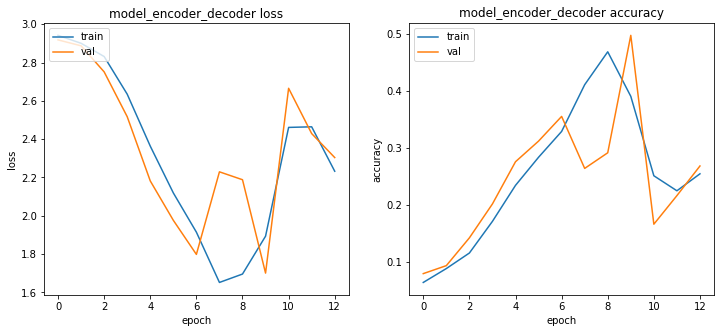

In [5]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

input [1, 9, 10, 19, 9, 9, 8, 14, 19, 15, 6, 19, 15, 10, 2, 19, 4, 18, 7, 6, 19, 8, 19, 5, 17, 17, 1, 6, 14, 13, 19, 3, 9, 13, 11, 1, 10, 16, 12, 15, 15, 9, 13, 2, 5, 17, 18, 14, 15, 7, 17, 17, 13, 1, 1, 15, 7, 18, 8, 16, 10, 15, 10, 16, 10, 3, 4, 5, 3, 14, 7, 17, 19, 14, 10, 17, 12, 7, 5, 13, 10, 6, 6, 7, 6, 18, 6, 9, 14, 14, 4, 10, 4, 7, 12, 15, 15, 16, 2, 5]
predicted [2, 4, 14, 4, 3, 6, 14, 6, 6, 6, 6, 6, 6, 6, 6, 10, 13, 6, 6, 10, 10, 5, 7, 12, 17, 10, 14, 14, 19, 17, 4, 4, 3, 10, 10, 16, 10, 10, 10, 16, 16, 8, 18, 7, 1, 1, 1, 17, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 9, 15, 15, 12, 16, 10, 1, 11, 13, 9, 3, 13, 13, 14, 6, 17, 17, 19, 19, 19, 19, 19, 4, 7, 19, 4, 4, 7, 10, 15, 15, 19, 15, 19, 19, 14, 9, 9, 9, 9, 9, 9]
expected [5, 2, 16, 15, 15, 12, 7, 4, 10, 4, 14, 14, 9, 6, 18, 6, 7, 6, 6, 10, 13, 5, 7, 12, 17, 10, 14, 19, 17, 7, 14, 3, 5, 4, 3, 10, 16, 10, 15, 10, 16, 8, 18, 7, 15, 1, 1, 13, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 9, 15, 15, 12, 16, 10, 1, 11, 13, 9, 3, 19, 13, 14, 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


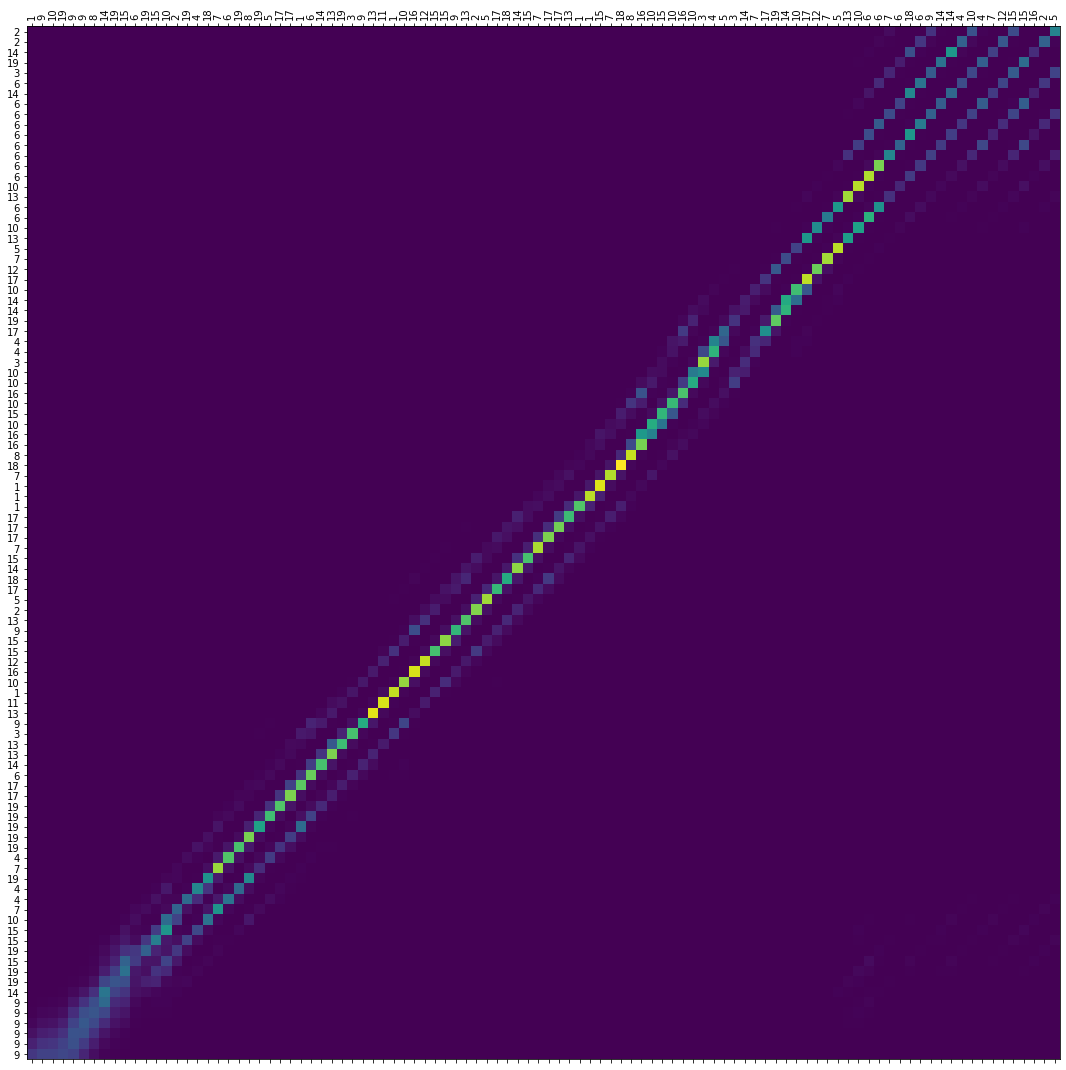

In [6]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

predict(model_attention, n_timesteps_in,n_features, X_batch, y_real, batch_size)
seq_in, seq_out, attention_plot = get_weights(X_batch, attention, encoder_lstm, decoder_lstm, decoder_dense)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

In [7]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################
        
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, query, values):
        
        ##################
        # YOUR CODE HERE #
        ##################
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

Epoch 1/50
180/180 [==============================] - 180s 375ms/step - loss: 2.9419 - accuracy: 0.0643 - val_loss: 2.9204 - val_accuracy: 0.0785
Epoch 2/50
180/180 [==============================] - 36s 201ms/step - loss: 2.8994 - accuracy: 0.0891 - val_loss: 2.8825 - val_accuracy: 0.0955
Epoch 3/50
180/180 [==============================] - 36s 200ms/step - loss: 2.8438 - accuracy: 0.1114 - val_loss: 2.7535 - val_accuracy: 0.1419
Epoch 4/50
180/180 [==============================] - 36s 199ms/step - loss: 2.5684 - accuracy: 0.1878 - val_loss: 2.3773 - val_accuracy: 0.2321
Epoch 5/50
180/180 [==============================] - 36s 200ms/step - loss: 2.3340 - accuracy: 0.2405 - val_loss: 2.0260 - val_accuracy: 0.3150
Epoch 6/50
180/180 [==============================] - 36s 199ms/step - loss: 1.9798 - accuracy: 0.3163 - val_loss: 2.0556 - val_accuracy: 0.2967
Epoch 7/50
180/180 [==============================] - 36s 198ms/step - loss: 1.9985 - accuracy: 0.3208 - val_loss: 1.5766 - val_a

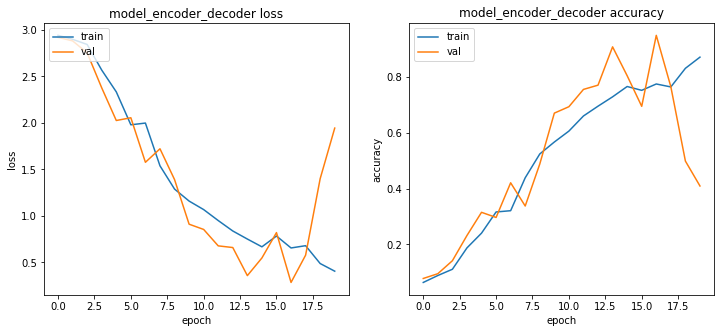

In [8]:
# training parameters
batch_size = 10

# model parameters
rnn_units = 80

# attention model
attention = BahdanauAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

input [1, 9, 10, 19, 9, 9, 8, 14, 19, 15, 6, 19, 15, 10, 2, 19, 4, 18, 7, 6, 19, 8, 19, 5, 17, 17, 1, 6, 14, 13, 19, 3, 9, 13, 11, 1, 10, 16, 12, 15, 15, 9, 13, 2, 5, 17, 18, 14, 15, 7, 17, 17, 13, 1, 1, 15, 7, 18, 8, 16, 10, 15, 10, 16, 10, 3, 4, 5, 3, 14, 7, 17, 19, 14, 10, 17, 12, 7, 5, 13, 10, 6, 6, 7, 6, 18, 6, 9, 14, 14, 4, 10, 4, 7, 12, 15, 15, 16, 2, 5]
predicted [5, 2, 16, 15, 15, 12, 7, 4, 10, 4, 14, 14, 9, 6, 18, 6, 7, 6, 6, 10, 13, 5, 7, 12, 17, 10, 14, 19, 17, 7, 14, 3, 5, 4, 3, 10, 16, 10, 15, 10, 16, 8, 18, 7, 15, 1, 1, 13, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 15, 15, 15, 16, 10, 10, 1, 11, 13, 9, 3, 19, 13, 14, 6, 1, 17, 17, 5, 19, 8, 19, 6, 7, 18, 4, 19, 2, 10, 15, 19, 6, 15, 19, 14, 9, 9, 9, 9, 10, 9, 1]
expected [5, 2, 16, 15, 15, 12, 7, 4, 10, 4, 14, 14, 9, 6, 18, 6, 7, 6, 6, 10, 13, 5, 7, 12, 17, 10, 14, 19, 17, 7, 14, 3, 5, 4, 3, 10, 16, 10, 15, 10, 16, 8, 18, 7, 15, 1, 1, 13, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 9, 15, 15, 12, 16, 10, 1, 11, 13, 9, 3, 19, 13, 14,

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


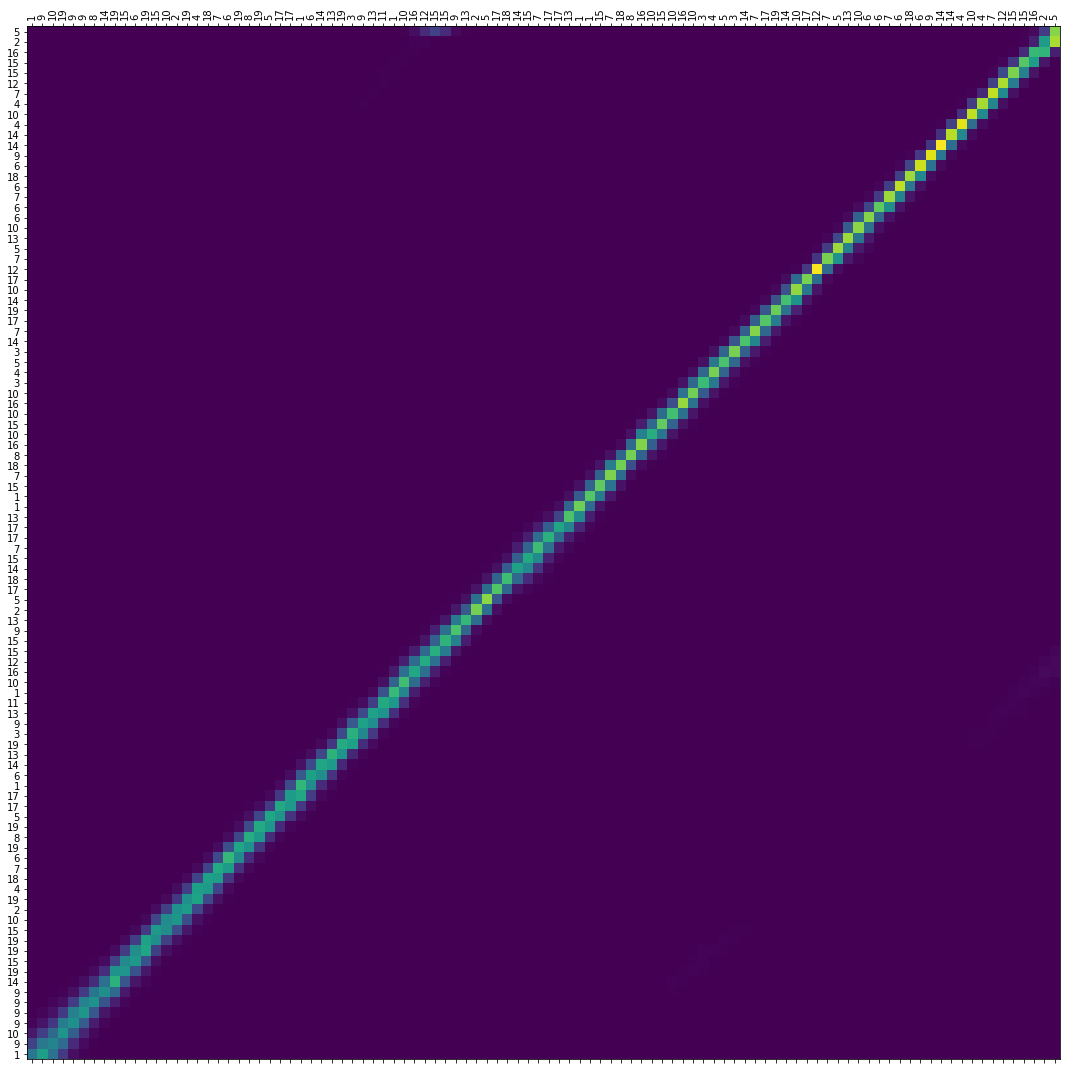

In [9]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

predict(model_attention, n_timesteps_in,n_features, X_batch, y_real, batch_size)
seq_in, seq_out, attention_plot = get_weights(X_batch, attention, encoder_lstm, decoder_lstm, decoder_dense)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

In [10]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(self.W(values), perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        ##################
        #Luong general
        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


Epoch 1/50
180/180 [==============================] - 175s 363ms/step - loss: 2.9412 - accuracy: 0.0640 - val_loss: 2.9196 - val_accuracy: 0.0791
Epoch 2/50
180/180 [==============================] - 33s 185ms/step - loss: 2.8979 - accuracy: 0.0902 - val_loss: 2.8844 - val_accuracy: 0.0974
Epoch 3/50
180/180 [==============================] - 33s 186ms/step - loss: 2.7493 - accuracy: 0.1419 - val_loss: 2.5648 - val_accuracy: 0.1948
Epoch 4/50
180/180 [==============================] - 34s 187ms/step - loss: 2.4291 - accuracy: 0.2212 - val_loss: 2.3195 - val_accuracy: 0.2392
Epoch 5/50
180/180 [==============================] - 34s 188ms/step - loss: 2.1494 - accuracy: 0.2818 - val_loss: 1.8976 - val_accuracy: 0.3390
Epoch 6/50
180/180 [==============================] - 34s 189ms/step - loss: 1.8531 - accuracy: 0.3432 - val_loss: 1.7250 - val_accuracy: 0.3592
Epoch 7/50
180/180 [==============================] - 34s 188ms/step - loss: 1.5288 - accuracy: 0.4308 - val_loss: 1.2719 - val_a

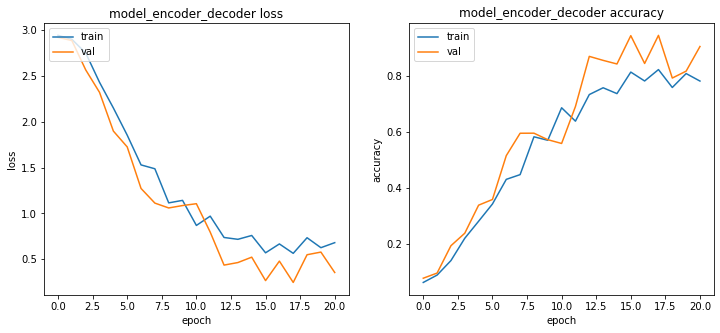

In [13]:
# training parameters
batch_size = 10

# model parameters
rnn_units = 80

# attention model
attention = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

input [1, 9, 10, 19, 9, 9, 8, 14, 19, 15, 6, 19, 15, 10, 2, 19, 4, 18, 7, 6, 19, 8, 19, 5, 17, 17, 1, 6, 14, 13, 19, 3, 9, 13, 11, 1, 10, 16, 12, 15, 15, 9, 13, 2, 5, 17, 18, 14, 15, 7, 17, 17, 13, 1, 1, 15, 7, 18, 8, 16, 10, 15, 10, 16, 10, 3, 4, 5, 3, 14, 7, 17, 19, 14, 10, 17, 12, 7, 5, 13, 10, 6, 6, 7, 6, 18, 6, 9, 14, 14, 4, 10, 4, 7, 12, 15, 15, 16, 2, 5]
predicted [5, 2, 16, 15, 15, 12, 7, 4, 10, 4, 14, 14, 9, 6, 18, 6, 7, 6, 6, 10, 13, 5, 7, 12, 17, 10, 14, 19, 17, 7, 14, 3, 5, 4, 3, 10, 10, 10, 15, 10, 16, 8, 18, 7, 15, 1, 1, 13, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 9, 15, 15, 12, 16, 10, 1, 11, 13, 9, 3, 19, 13, 14, 6, 1, 17, 17, 5, 19, 8, 19, 6, 7, 18, 4, 19, 2, 10, 15, 15, 19, 6, 19, 14, 8, 9, 9, 9, 10, 9, 1]
expected [5, 2, 16, 15, 15, 12, 7, 4, 10, 4, 14, 14, 9, 6, 18, 6, 7, 6, 6, 10, 13, 5, 7, 12, 17, 10, 14, 19, 17, 7, 14, 3, 5, 4, 3, 10, 16, 10, 15, 10, 16, 8, 18, 7, 15, 1, 1, 13, 17, 17, 7, 15, 14, 18, 17, 5, 2, 13, 9, 15, 15, 12, 16, 10, 1, 11, 13, 9, 3, 19, 13, 14, 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


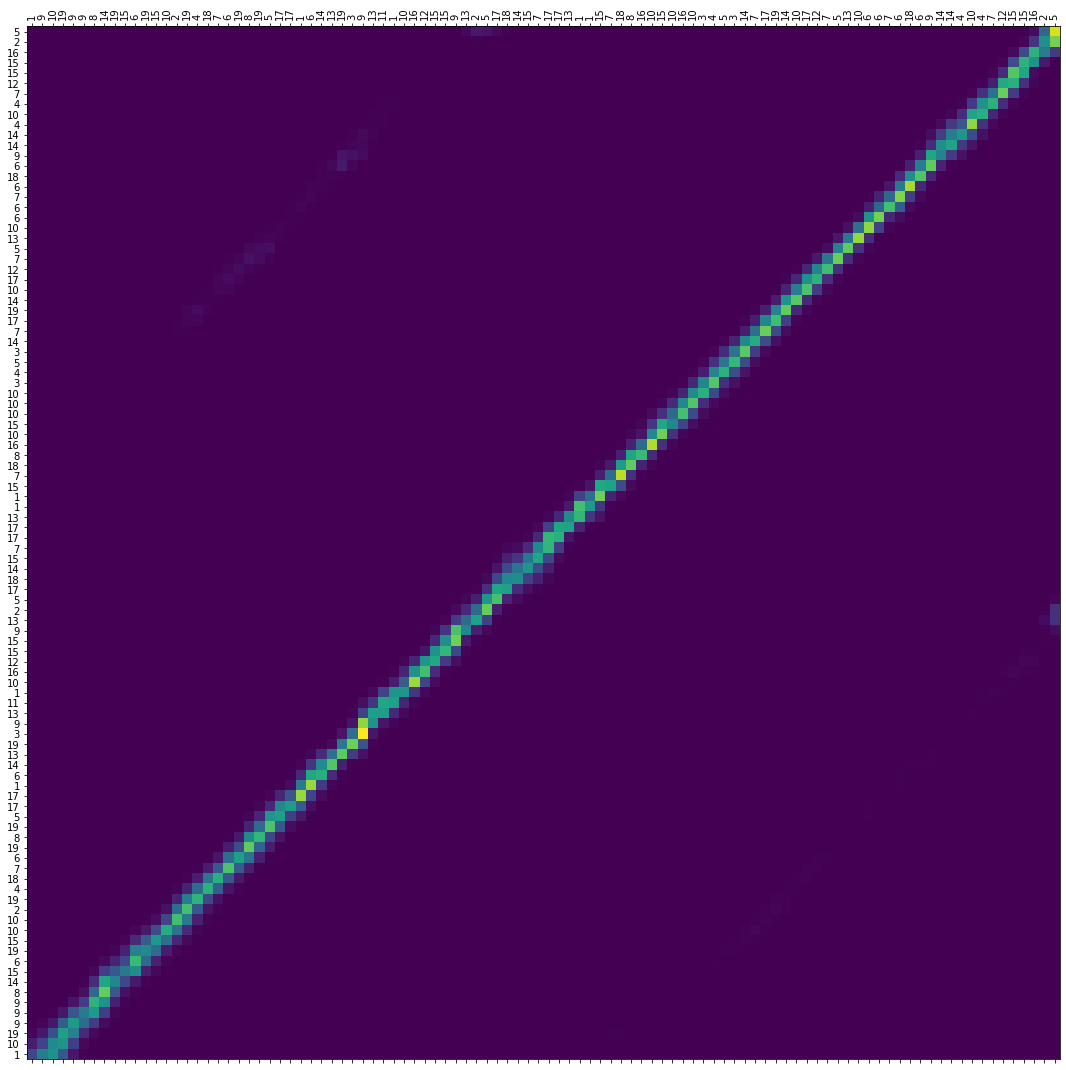

In [14]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

predict(model_attention, n_timesteps_in,n_features, X_batch, y_real, batch_size)
seq_in, seq_out, attention_plot = get_weights(X_batch, attention, encoder_lstm, decoder_lstm, decoder_dense)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

# Comparative

Bahdanau's Attention weight calculation is an additive calculation, and the attention layer of the decoder is completed before the LSTM layer of the encoder, but each calculation must take into account all the hidden states of the encoder, and the calculation cost is relatively high. The scoring function provides the probability of the importance of each hidden state at the current time step.
When calculating the context vector, Luong Attention uses the method of weight calculation, which is much faster. Suitable for long sentences or documents. Its main difference is that only the hidden state from the top RNN layer is used during encoding, which allows both the encoder and decoder to be a stack of RNNs. Essentially, the first option is dot, which is the dot product of the hidden state of the encoder (h_s) and the hidden state of the decoder (h_t). General Luong is different from an intermediate operation of multiplying by weight, so we have more local and global attention.In resume, Luong uses simple matrix multiplication makes it is faster and more space-efficient.

# Blog
https://hackmd.io/@johnnync13/r1Rhb7J2t

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

